In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics # For F1 score

# 0. Pre-processing

In [2]:
bmi_df = pd.read_csv('./fuzzy_macros_dataset_bmi.csv') # Using the provided dataset name
bmi_df.head()

,BMI,BodyFat,Sex,Age,Protein_g,Calories_kcal,Fat_g,Carbohydrates_g
0,21.45,13.6,F,19,135.1,1801,60.0,180.1
1,23.53,8.8,M,57,161.2,2150,71.7,215.0
2,22.15,23.1,F,20,144.2,1923,64.1,192.3
3,23.61,11.9,M,32,189.7,2529,84.3,252.9
4,21.47,17.6,F,18,144.4,1925,64.2,192.5


### Data Cleaning and Feature Engineering (Simplified from original)

In [3]:
# Focus on relevant columns for this fuzzy system
df_cleaned = bmi_df[['BMI', 'BodyFat', 'Sex', 'Age', 'Protein_g']].copy()
print(f"Initial data count: {df_cleaned.shape[0]}")

# Basic Physiological Filtering (based on fuzzy system definitions in .md files)
df_cleaned = df_cleaned[(df_cleaned['Age'] >= 18) & (df_cleaned['Age'] <= 80)]
df_cleaned = df_cleaned[(df_cleaned['BMI'] >= 15) & (df_cleaned['BMI'] <= 50)]
df_cleaned = df_cleaned[~((df_cleaned['Sex'] == 'M') & ((df_cleaned['BodyFat'] < 2) | (df_cleaned['BodyFat'] > 60)))]
df_cleaned = df_cleaned[~((df_cleaned['Sex'] == 'F') & ((df_cleaned['BodyFat'] < 10) | (df_cleaned['BodyFat'] > 60)))]
# Protein_g universe for MFs: [50, 200]. We'll use a slightly wider range for actual data to avoid excessive removal.
df_cleaned = df_cleaned[(df_cleaned['Protein_g'] >= 30) & (df_cleaned['Protein_g'] <= 250)]

print(f"Data count after physiological filtering: {df_cleaned.shape[0]}")

# Optional: IQR outlier removal on relevant columns if still needed (can be aggressive)
for column in ['BMI', 'BodyFat', 'Age', 'Protein_g']:
    Q1 = df_cleaned[column].quantile(0.25)
    Q3 = df_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    before_iqr = df_cleaned.shape[0]
    df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    after_iqr = df_cleaned.shape[0]
    if before_iqr - after_iqr > 0:
      print(f"{column}: Dihapus {before_iqr - after_iqr} data outlier via IQR")

print(f"Data count after IQR filtering: {df_cleaned.shape[0]}")
bmi_df = df_cleaned.reset_index(drop=True) # Reset index for clean iteration

Initial data count: 95
Data count after physiological filtering: 94
Data count after IQR filtering: 94


# 1. Linguistic variables and memberships

In [4]:
def trapmf(x, abcd):
    a, b, c, d = abcd
    if a > b: raise ValueError('a > b')
    if b > c: raise ValueError('b > c') # Allow b == c for triangular
    if c > d: raise ValueError('c > d')
        
    y = np.zeros_like(x if isinstance(x, np.ndarray) else [x])
    
    # Handle scalar input
    if not isinstance(x, np.ndarray):
        x = np.array([x])
        y = np.zeros_like(x, dtype=float)
        single_value = True
    else:
        y = np.zeros_like(x, dtype=float)
        single_value = False

    # Left slope
    if a != b:
        idx = np.logical_and(x >= a, x < b)
        y[idx] = (x[idx] - a) / (b - a)

    # Top part
    idx = np.logical_and(x >= b, x <= c)
    y[idx] = 1

    # Right slope
    if c != d:
        idx = np.logical_and(x > c, x <= d)
        y[idx] = (d - x[idx]) / (d - c)

    return y[0] if single_value else y
        
    return y[0] if isinstance(y, np.ndarray) and y.size == 1 else y

def trimf(x, abc):
    a, b, c = abc
    return trapmf(x, [a, b, b, c])

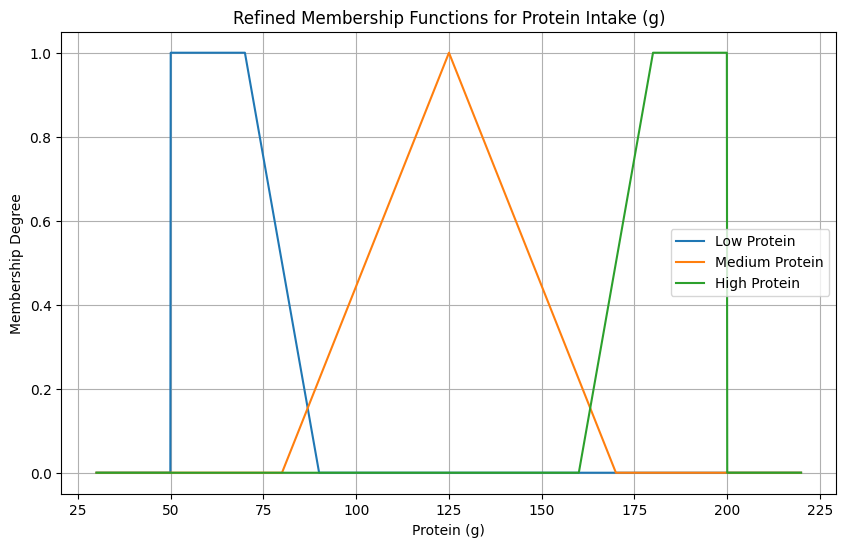

In [5]:
# Input: BMI (kg/m²)
def bmi_underweight(bmi):
    return trapmf(bmi, [15, 15, 17, 18.5])
def bmi_normal(bmi):
    return trimf(bmi, [17, 21.75, 25])
def bmi_overweight(bmi):
    return trimf(bmi, [25, 27.5, 30])
def bmi_obese(bmi):
    return trapmf(bmi, [30, 35, 50, 50])

# Input: BodyFat % (Men)
def bfm_lean(bodyfat):
    return trapmf(bodyfat, [2, 2, 8, 14])
def bfm_normal(bodyfat):
    return trimf(bodyfat, [10, 18, 25])
def bfm_high(bodyfat):
    return trapmf(bodyfat, [20, 30, 60, 60])

# Input: BodyFat % (Women)
def bfw_lean(bodyfat):
    return trapmf(bodyfat, [10, 10, 18, 24])
def bfw_normal(bodyfat):
    return trimf(bodyfat, [20, 28, 35])
def bfw_high(bodyfat):
    return trapmf(bodyfat, [30, 40, 60, 60])

# Input: Age (years)
def age_young(age):
    return trapmf(age, [18, 18, 25, 40])
def age_middle(age):
    return trimf(age, [30, 45, 60])
def age_senior(age):
    return trapmf(age, [50, 65, 80, 80])

# Output: Protein Intake (g) - Mamdani (Refined for better spread and overlap)
def protein_low_mf(protein):
    return trapmf(protein, [50, 50, 70, 90]) # Covers up to ~80g (center of Low Sugeno)
def protein_medium_mf(protein):
    return trimf(protein, [80, 125, 170]) # Centered around 125g (Medium Sugeno)
def protein_high_mf(protein):
    return trapmf(protein, [160, 180, 200, 200]) # Covers from ~170g upwards (High Sugeno)

# Sugeno Constants for Protein (from .md)
protein_sugeno_constants = {
    'Low': 80,
    'Medium': 125,
    'High': 170
}

# Visualize Protein MFs
x_protein_vis = np.arange(30, 220, 0.1)
plt.figure(figsize=(10,6))
plt.plot(x_protein_vis, protein_low_mf(x_protein_vis), label='Low Protein')
plt.plot(x_protein_vis, protein_medium_mf(x_protein_vis), label='Medium Protein')
plt.plot(x_protein_vis, protein_high_mf(x_protein_vis), label='High Protein')
plt.title('Refined Membership Functions for Protein Intake (g)')
plt.xlabel('Protein (g)')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

# 2. Fuzzification

In [6]:
bmi_terms = {
    'Underweight': bmi_underweight,
    'Normal': bmi_normal,
    'Overweight': bmi_overweight,
    'Obese': bmi_obese
}
bfm_terms = { # Men
    'Lean_M': bfm_lean, 
    'Normal_M': bfm_normal, 
    'High_M': bfm_high
}
bfw_terms = { # Women
    'Lean_F': bfw_lean, 
    'Normal_F': bfw_normal, 
    'High_F': bfw_high
}
age_terms = {
    'Young': age_young,
    'Middle': age_middle,
    'Senior': age_senior
}
protein_output_terms = {
    'Low': protein_low_mf,
    'Medium': protein_medium_mf,
    'High': protein_high_mf
}

In [7]:
def fuzzify_all_inputs(bmi_val, bodyfat_val, sex_val, age_val):
    f_bmi = {term: mf(bmi_val) for term, mf in bmi_terms.items()}
    bodyfat_terms_to_use = bfm_terms if sex_val == 'M' else bfw_terms
    f_bf = {term: mf(bodyfat_val) for term, mf in bodyfat_terms_to_use.items()}
    f_age = {term: mf(age_val) for term, mf in age_terms.items()}
    return f_bmi, f_bf, f_age

# Example Fuzzification for Protein
example_bmi_p, example_bf_p, example_sex_p, example_age_p = 22, 15, 'M', 30
fuzz_bmi_p, fuzz_bf_p, fuzz_age_p = fuzzify_all_inputs(example_bmi_p, example_bf_p, example_sex_p, example_age_p)
print(f"Fuzzified BMI for {example_bmi_p}: {fuzz_bmi_p}")
print(f"Fuzzified BodyFat ({example_sex_p}) for {example_bf_p}%: {fuzz_bf_p}")
print(f"Fuzzified Age for {example_age_p} years: {fuzz_age_p}")

Fuzzified BMI for 22: {'Underweight': np.float64(0.0), 'Normal': np.float64(0.9230769230769231), 'Overweight': np.float64(0.0), 'Obese': np.float64(0.0)}
Fuzzified BodyFat (M) for 15%: {'Lean_M': np.float64(0.0), 'Normal_M': np.float64(0.625), 'High_M': np.float64(0.0)}
Fuzzified Age for 30 years: {'Young': np.float64(0.6666666666666666), 'Middle': np.float64(0.0), 'Senior': np.float64(0.0)}


# 3. Inference (Rules)

In [8]:
# Protein Rules (Sex, BMI_Term, BodyFat_Term, Age_Term, Protein_Output_Term)
protein_rules = [
    # Men
    ('M', 'Underweight', 'Lean_M', 'Young', 'Medium'),
    ('M', 'Underweight', 'Lean_M', 'Middle', 'Medium'),
    ('M', 'Underweight', 'Lean_M', 'Senior', 'Low'),
    ('M', 'Underweight', 'Normal_M', 'Young', 'Low'),
    ('M', 'Underweight', 'Normal_M', 'Middle', 'Low'),
    ('M', 'Underweight', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Underweight', 'High_M', 'Young', 'Low'),
    ('M', 'Underweight', 'High_M', 'Middle', 'Low'),
    ('M', 'Underweight', 'High_M', 'Senior', 'Low'),
    ('M', 'Normal', 'Lean_M', 'Young', 'High'),
    ('M', 'Normal', 'Lean_M', 'Middle', 'High'),
    ('M', 'Normal', 'Lean_M', 'Senior', 'Low'), 
    ('M', 'Normal', 'Normal_M', 'Young', 'High'),
    ('M', 'Normal', 'Normal_M', 'Middle', 'Medium'),
    ('M', 'Normal', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Normal', 'High_M', 'Young', 'Low'),
    ('M', 'Normal', 'High_M', 'Middle', 'Low'),
    ('M', 'Normal', 'High_M', 'Senior', 'Low'),
    ('M', 'Overweight', 'Lean_M', 'Young', 'High'),
    ('M', 'Overweight', 'Lean_M', 'Middle', 'High'),
    ('M', 'Overweight', 'Lean_M', 'Senior', 'Low'),
    ('M', 'Overweight', 'Normal_M', 'Young', 'High'),
    ('M', 'Overweight', 'Normal_M', 'Middle', 'High'),
    ('M', 'Overweight', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Overweight', 'High_M', 'Young', 'Low'),
    ('M', 'Overweight', 'High_M', 'Middle', 'Low'),
    ('M', 'Overweight', 'High_M', 'Senior', 'Low'),
    ('M', 'Obese', 'Lean_M', 'Young', 'Medium'), 
    ('M', 'Obese', 'Lean_M', 'Middle', 'Low'),
    ('M', 'Obese', 'Lean_M', 'Senior', 'Low'),
    ('M', 'Obese', 'Normal_M', 'Young', 'Medium'),
    ('M', 'Obese', 'Normal_M', 'Middle', 'Low'),
    ('M', 'Obese', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Obese', 'High_M', 'Young', 'Low'),
    ('M', 'Obese', 'High_M', 'Middle', 'Low'),
    ('M', 'Obese', 'High_M', 'Senior', 'Low'),
    # Women
    ('F', 'Underweight', 'Lean_F', 'Young', 'Medium'),
    ('F', 'Underweight', 'Lean_F', 'Middle', 'Medium'),
    ('F', 'Underweight', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Young', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Middle', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Underweight', 'High_F', 'Young', 'Low'),
    ('F', 'Underweight', 'High_F', 'Middle', 'Low'),
    ('F', 'Underweight', 'High_F', 'Senior', 'Low'),
    ('F', 'Normal', 'Lean_F', 'Young', 'High'),
    ('F', 'Normal', 'Lean_F', 'Middle', 'High'),
    ('F', 'Normal', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Normal', 'Normal_F', 'Young', 'High'),
    ('F', 'Normal', 'Normal_F', 'Middle', 'Medium'),
    ('F', 'Normal', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Normal', 'High_F', 'Young', 'Low'),
    ('F', 'Normal', 'High_F', 'Middle', 'Low'),
    ('F', 'Normal', 'High_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'Lean_F', 'Young', 'High'),
    ('F', 'Overweight', 'Lean_F', 'Middle', 'High'),
    ('F', 'Overweight', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'Normal_F', 'Young', 'High'),
    ('F', 'Overweight', 'Normal_F', 'Middle', 'High'),
    ('F', 'Overweight', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'High_F', 'Young', 'Low'),
    ('F', 'Overweight', 'High_F', 'Middle', 'Low'),
    ('F', 'Overweight', 'High_F', 'Senior', 'Low'),
    ('F', 'Obese', 'Lean_F', 'Young', 'Medium'),
    ('F', 'Obese', 'Lean_F', 'Middle', 'Low'),
    ('F', 'Obese', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Obese', 'Normal_F', 'Young', 'Medium'),
    ('F', 'Obese', 'Normal_F', 'Middle', 'Low'),
    ('F', 'Obese', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Obese', 'High_F', 'Young', 'Low'),
    ('F', 'Obese', 'High_F', 'Middle', 'Low'),
    ('F', 'Obese', 'High_F', 'Senior', 'Low'),
]

In [9]:
def apply_protein_rules(fuzz_bmi, fuzz_bf, fuzz_age, sex_input):
    aggregated_mamdani_strengths = {term: 0.0 for term in protein_output_terms}
    sugeno_rule_outputs = []
    active_rules_details_list = []

    for rule_sex, bmi_term, bf_term, age_term, protein_consequent_term in protein_rules:
        if rule_sex != sex_input:
            continue

        bmi_strength = fuzz_bmi.get(bmi_term, 0)
        bf_strength = fuzz_bf.get(bf_term, 0)
        age_strength = fuzz_age.get(age_term, 0)
        
        rule_strength = min(bmi_strength, bf_strength, age_strength)
        
        if rule_strength > 0:
            active_rules_details_list.append({
                'Sex': rule_sex,
                'BMI Term': bmi_term, 'BMI Strength': bmi_strength,
                'BF Term': bf_term, 'BF Strength': bf_strength,
                'Age Term': age_term, 'Age Strength': age_strength,
                'Protein Consequent': protein_consequent_term,
                'Rule Strength': rule_strength
            })
            
            aggregated_mamdani_strengths[protein_consequent_term] = max(
                aggregated_mamdani_strengths[protein_consequent_term], rule_strength
            )
            
            sugeno_consequent_value = protein_sugeno_constants[protein_consequent_term]
            sugeno_rule_outputs.append((rule_strength, sugeno_consequent_value))
            
    return aggregated_mamdani_strengths, sugeno_rule_outputs, pd.DataFrame(active_rules_details_list)

In [10]:
# Example rule application for Protein
agg_mamdani_p, sug_outputs_p, active_rules_df_p = apply_protein_rules(fuzz_bmi_p, fuzz_bf_p, fuzz_age_p, example_sex_p)
print("Aggregated Mamdani Strengths (Protein):", agg_mamdani_p)
print("\nSugeno Rule Outputs (Protein - strength, consequent_value):", sug_outputs_p)
print("\nActive Rules Details (Protein):")
if not active_rules_df_p.empty:
    display(active_rules_df_p)
else:
    print("No rules activated for the given inputs.")

Aggregated Mamdani Strengths (Protein): {'Low': 0.0, 'Medium': 0.0, 'High': np.float64(0.625)}

Sugeno Rule Outputs (Protein - strength, consequent_value): [(np.float64(0.625), 170)]

Active Rules Details (Protein):


,Sex,BMI Term,BMI Strength,BF Term,BF Strength,Age Term,Age Strength,Protein Consequent,Rule Strength
0,M,Normal,0.923077,Normal_M,0.625,Young,0.666667,High,0.625


# 4. Defuzzification (Mamdani & Sugeno)

In [11]:
protein_universe_defuzz = np.arange(50, 201, 1) # Protein output universe

def defuzzify_mamdani_centroid_protein(aggregated_strengths, output_universe):
    numerator = 0
    denominator = 0
    aggregated_mf_plot_values = np.zeros_like(output_universe, dtype=float)

    for i, protein_val in enumerate(output_universe):
        max_membership_for_val = 0
        for protein_term, strength in aggregated_strengths.items():
            if strength > 0:
                clipped_value = min(protein_output_terms[protein_term](protein_val), strength)
                max_membership_for_val = max(max_membership_for_val, clipped_value)
        aggregated_mf_plot_values[i] = max_membership_for_val
        numerator += protein_val * max_membership_for_val
        denominator += max_membership_for_val
        
    if denominator == 0:
        return 0
    return numerator / denominator

mamdani_protein_pred = defuzzify_mamdani_centroid_protein(agg_mamdani_p, protein_universe_defuzz)
print(f"Predicted Protein (Mamdani Centroid) for example: {mamdani_protein_pred:.2f}g")

Predicted Protein (Mamdani Centroid) for example: 183.19g


In [12]:
def defuzzify_sugeno_weighted_average_protein(sugeno_rule_outputs_list):
    numerator = 0
    denominator = 0
    if not sugeno_rule_outputs_list: return 0
    for strength, consequent_value in sugeno_rule_outputs_list:
        numerator += strength * consequent_value
        denominator += strength
    if denominator == 0: return 0
    return numerator / denominator

sugeno_protein_pred = defuzzify_sugeno_weighted_average_protein(sug_outputs_p)
print(f"Predicted Protein (Sugeno Weighted Average) for example: {sugeno_protein_pred:.2f}g")

Predicted Protein (Sugeno Weighted Average) for example: 170.00g


# 5. Evaluation

In [13]:
mamdani_protein_predictions_eval = []
sugeno_protein_predictions_eval = []
actual_protein_values_eval = []

for index, row in bmi_df.iterrows(): # Use the cleaned bmi_df
    bmi_val = row['BMI']
    bodyfat_val = row['BodyFat']
    sex_val = row['Sex']
    age_val = row['Age']
    actual_protein = row['Protein_g']
    
    f_bmi, f_bf, f_age = fuzzify_all_inputs(bmi_val, bodyfat_val, sex_val, age_val)
    agg_mamdani_strengths, sug_rule_outputs, _ = apply_protein_rules(f_bmi, f_bf, f_age, sex_val)
    
    mamdani_pred = defuzzify_mamdani_centroid_protein(agg_mamdani_strengths, protein_universe_defuzz)
    sugeno_pred = defuzzify_sugeno_weighted_average_protein(sug_rule_outputs)
    
    mamdani_protein_predictions_eval.append(mamdani_pred)
    sugeno_protein_predictions_eval.append(sugeno_pred)
    actual_protein_values_eval.append(actual_protein)

bmi_df['Protein_Mamdani_Predicted'] = mamdani_protein_predictions_eval
bmi_df['Protein_Sugeno_Predicted'] = sugeno_protein_predictions_eval

print("\n--- Sample of Actual vs Predicted Protein (with predictions) ---")
print(bmi_df[['Protein_g', 'Protein_Mamdani_Predicted', 'Protein_Sugeno_Predicted']].head())


--- Sample of Actual vs Predicted Protein (with predictions) ---
   Protein_g  Protein_Mamdani_Predicted  Protein_Sugeno_Predicted
0      135.1                 184.466655                 170.00000
1      161.2                 104.088021                 107.59434
2      144.2                 182.125110                 170.00000
3      189.7                 155.252374                 162.97561
4      144.4                 184.482593                 170.00000


In [14]:
# F1 Score Evaluation for Protein
# Bins based on Sugeno constants midpoints: Low up to (80+125)/2 = 102.5; Medium up to (125+170)/2 = 147.5; High above
protein_bins_edges_eval = [0, 102.5, 147.5, float('inf')] # Updated based on Sugeno constants
protein_labels_eval = [0, 1, 2] # Representing Low, Medium, High

actual_protein_binned_eval = pd.cut(bmi_df['Protein_g'], bins=protein_bins_edges_eval, labels=protein_labels_eval, include_lowest=True, duplicates='drop')
mamdani_protein_binned_eval = pd.cut(bmi_df['Protein_Mamdani_Predicted'], bins=protein_bins_edges_eval, labels=protein_labels_eval, include_lowest=True, duplicates='drop')
sugeno_protein_binned_eval = pd.cut(bmi_df['Protein_Sugeno_Predicted'], bins=protein_bins_edges_eval, labels=protein_labels_eval, include_lowest=True, duplicates='drop')

valid_indices_mamdani_p = actual_protein_binned_eval.notna() & mamdani_protein_binned_eval.notna()
valid_indices_sugeno_p = actual_protein_binned_eval.notna() & sugeno_protein_binned_eval.notna()

if valid_indices_mamdani_p.sum() > 0 and len(np.unique(actual_protein_binned_eval[valid_indices_mamdani_p])) > 1:
    f1_mamdani_protein = metrics.f1_score(actual_protein_binned_eval[valid_indices_mamdani_p], mamdani_protein_binned_eval[valid_indices_mamdani_p], average='macro', zero_division=0)
    print(f"\nF1 Score (Mamdani Protein - Binned): {f1_mamdani_protein:.4f}")
else:
    print("\nCould not calculate Mamdani F1 score for Protein due to insufficient data or only one class present.")

if valid_indices_sugeno_p.sum() > 0 and len(np.unique(actual_protein_binned_eval[valid_indices_sugeno_p])) > 1:
    f1_sugeno_protein = metrics.f1_score(actual_protein_binned_eval[valid_indices_sugeno_p], sugeno_protein_binned_eval[valid_indices_sugeno_p], average='macro', zero_division=0)
    print(f"F1 Score (Sugeno Protein - Binned): {f1_sugeno_protein:.4f}")
else:
    print("\nCould not calculate Sugeno F1 score for Protein due to insufficient data or only one class present.")


F1 Score (Mamdani Protein - Binned): 0.2583
F1 Score (Sugeno Protein - Binned): 0.2617


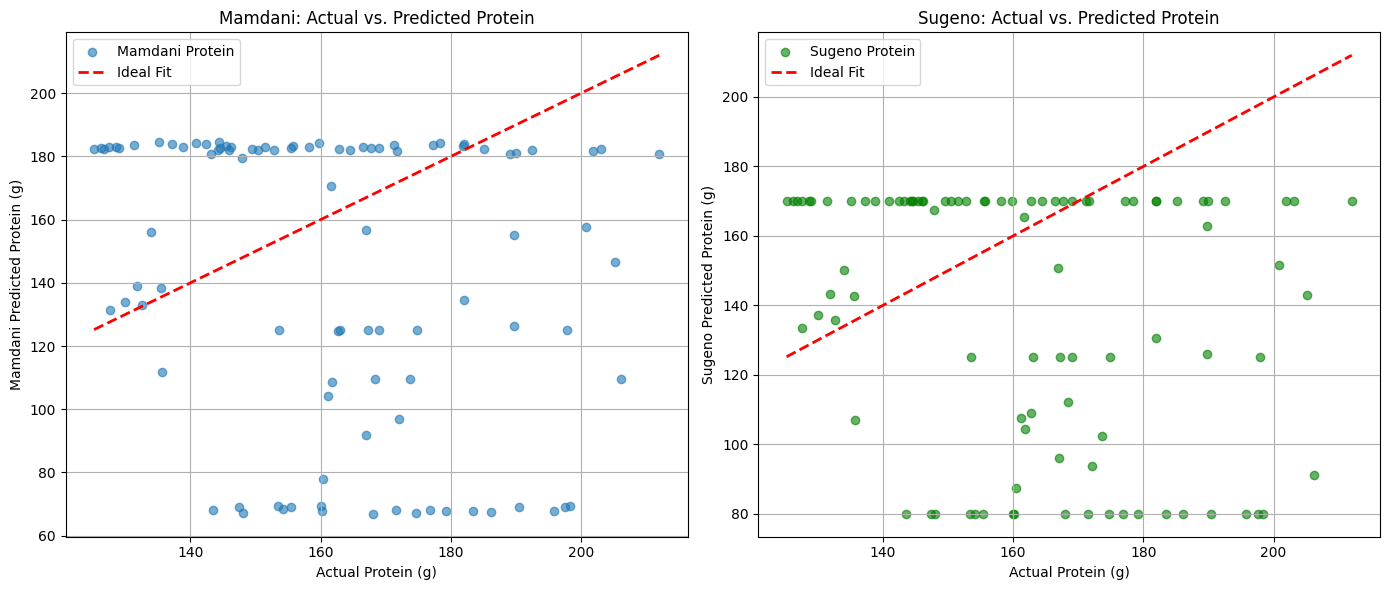

In [15]:
# Scatter plot of Actual vs. Predicted Protein
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(bmi_df['Protein_g'], bmi_df['Protein_Mamdani_Predicted'], alpha=0.6, label='Mamdani Protein')
plt.plot([bmi_df['Protein_g'].min(), bmi_df['Protein_g'].max()], 
         [bmi_df['Protein_g'].min(), bmi_df['Protein_g'].max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Protein (g)')
plt.ylabel('Mamdani Predicted Protein (g)')
plt.title('Mamdani: Actual vs. Predicted Protein')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(bmi_df['Protein_g'], bmi_df['Protein_Sugeno_Predicted'], alpha=0.6, color='green', label='Sugeno Protein')
plt.plot([bmi_df['Protein_g'].min(), bmi_df['Protein_g'].max()], 
         [bmi_df['Protein_g'].min(), bmi_df['Protein_g'].max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Protein (g)')
plt.ylabel('Sugeno Predicted Protein (g)')
plt.title('Sugeno: Actual vs. Predicted Protein')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()